# Data Preprocessing

In [1]:
# Imports
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

pd.set_option('display.max_columns', None)
from matplotlib.colors import LinearSegmentedColormap
from sklearn.neighbors import NearestNeighbors
from sklearn import datasets
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline
from sklearn.metrics import silhouette_samples, silhouette_score
import matplotlib.cm as cm
import seaborn as sns
%matplotlib inline

In [2]:
# Read data
df = pd.read_csv('BehaviourData.csv', sep = ',', dtype = None)

# Remove qweek and contact in house
df.drop(['qweek',
         'i1_health'
        ], axis = 1, inplace = True)

In [3]:
# Rename
df.rename({'i2_health' : "NumContact",
           'i7a_health': 'LeaveHouse', 
           'i3_health': 'CovidResult',
           'i4_health': 'HouseCovid',
           'i5_health_1': 'Cough',
           'i5_health_2': 'Fever',
           'i5_health_3': 'Smell',
           'i5_health_4': 'Taste',
           'i5_health_5': 'Breathing',
           'i5_health_99': 'NoSymptoms',
           'i5a_health': 'CovidContact',
           'i6_health': 'SelfIsolationLevel',
           'i7b_health': 'HealthCareVisit',
           'i8_health': 'PriorTravel',
           'i9_health': 'WouldIsolate',
           'i10_health': 'IsolationDifficulty',
           'i11_health': 'IsolationWillingness',
           'i12_health_1': 'Mask',
           'i12_health_2': 'Soap',
           'i12_health_3': 'HandSanitiser',
           'i12_health_4': 'CoverSneeze',
           'i12_health_5': 'AvoidContact',
           'i12_health_6': 'AvoidGoingOut',
           'i12_health_7': 'AvoidHealthcare',
           'i12_health_8': 'AvoidTransit',
           'i12_health_9': 'AvoidWorkingOutside',
           'i12_health_10': 'AvoidAcademics',
           'i12_health_11': 'AvoidGuests',
           'i12_health_12': 'AvoidSmallGatherings',
           'i12_health_13': 'AvoidMedGatherings',
           'i12_health_14': 'AvoidLargeGatherings',
           'i12_health_15': 'AvoidCrowds',
           'i12_health_16': 'AvoidShops',
           'i12_health_17': 'AvoidSharedBedroom',
           'i12_health_18': 'EatSeperately',
           'i12_health_19': 'CleanSurfaces',
           'i12_health_20': 'AvoidPublicObjects',
           'i13_health': 'NumHandWash',
           'i14_health_1': 'Construction',
           'i14_health_2': 'HomeDelivery',
           'i14_health_3': 'FoodRetail',
           'i14_health_4': 'Healthcare',
           'i14_health_5': 'Logistics',
           'i14_health_6': 'Manufacturing',
           'i14_health_7': 'Police',
           'i14_health_8': 'PublicTransport',
           'i14_health_9': 'School',
           'i14_health_10': 'SocialCare',
           'i14_health_96': 'Other',
           'i14_health_98': 'NotSure',
           'i14_health_99': 'WorkFromHome',
           'i14_health_other': 'HealthOther',
           'd1_health_1': 'Arthritis',
           'd1_health_2': 'Athsma',
           'd1_health_3': 'Cancer',
           'd1_health_4': 'CysticFibrosis',
           'd1_health_5': 'COPD',
           'd1_health_6': 'Diabetes',
           'd1_health_7': 'Eplilepsy',
           'd1_health_8': 'HeartDisease',
           'd1_health_9': 'HighBloodPressure',
           'd1_health_10': 'HighCholesterol',
           'd1_health_11': 'HIV',
           'd1_health_12': 'MentalHealth',
           'd1_health_13': 'MS',
           'd1_health_98': 'NotSay',
           'd1_health_99': 'NoneHealth',
           'weight': 'Weight',
           'age': 'Age',
           'region_state': 'Region',
           'gender': 'Gender',
           'household_size': 'HouseholdSize',
           'household_children': 'HouseholdChildren',
           'employment_status': 'EmploymentStatus'
           }, axis=1, inplace=True)


In [4]:
# Bucket age
def makeBins_manual(column, label, bins):
    df[f'{column}Bin'] = pd.cut(df[column], bins=bins, labels=labels, include_lowest=True)

# Bucket age into 3 groups 
labels = ['adolecent', 'adult', 'elderly']
ageBins = [0,20,65,100]
makeBins_manual('Age', labels, ageBins)

In [5]:
# If there is any immunocomprimising, set true
df['UnderlyingHealth'] =  (df.Cancer == 'Yes') | (df.CysticFibrosis == 'Yes') |(df.COPD == 'Yes') |(df.Diabetes == 'Yes') |(df.HeartDisease == 'Yes')  |(df.HIV == 'Yes') |(df.MS == 'Yes')
# No Mental Health or Athsma or Arthritis or Eplilepsy OR HighBloodPressure OR HighCholesterol

# Create binary symptom columns
df['HasSymptoms'] = (((df.Cough == 'Yes') | (df.Fever == 'Yes') | (df.Smell == 'Yes') | (df.Taste == 'Yes') | (df.Breathing == 'Yes')) & (df.NoSymptoms == 'No') )

# Predictor bucketed, I think this can maybe stay as it was
df['MaskBucket'] = df['Mask'].map({'Always' : 'Yes', 'Frequently' : 'Yes', 'Sometimes' : 'No',  'Rarely' : 'No', 'Not at all' : 'No'})


In [16]:
# Replace household children with binary
df['HasChildren'] = (df['HouseholdChildren'] != '0')

# Drop used columns
df = df.drop(['HouseholdChildren', 'HealthOther'], axis=1)
df = df.drop(['Index', 'RecordNo', 'endtime', 'Region'],axis = 1)
df = df.drop(['Athsma', 'Arthritis', 'MentalHealth','Cancer', 'HighBloodPressure', 'HighCholesterol', 'CysticFibrosis', 'COPD', 'Diabetes', 'HeartDisease', 'HIV', 'MS', 'Eplilepsy'], axis=1)
df = df.drop(['Cough', 'Fever', 'Smell', 'Taste', 'Breathing', 'NoSymptoms'],axis = 1)

# I dont like these, maybe we want to keep though
df = df.drop(['AvoidContact', 'AvoidGoingOut', 'AvoidHealthcare', 'AvoidTransit', 'AvoidWorkingOutside', 'AvoidAcademics', 'AvoidGuests', 'AvoidSmallGatherings', 'AvoidMedGatherings', 'AvoidLargeGatherings', 'AvoidCrowds', 'AvoidShops', 'AvoidSharedBedroom', 'AvoidPublicObjects'], axis = 1)

# Fill blanks with No or their equiv
df['CovidContact'] = df['CovidContact'].replace(r'^\s+$', 'No', regex=True)
df['SelfIsolationLevel'] = df['SelfIsolationLevel'].replace(r'^\s+$', 'Not at all', regex=True)
df['HealthCareVisit'] = df['HealthCareVisit'].replace(r'^\s+$', 'No', regex=True)
df['IsolationDifficulty'] = df['IsolationDifficulty'].replace(r'^\s+$', 'Very difficult', regex=True)
df['WouldIsolate'] = df['WouldIsolate'].replace(r'^\s+$', 'No', regex=True)
df['IsolationWillingness'] = df['IsolationWillingness'].replace(r'^\s+$', 'Very unwilling', regex=True)
df['CovidResult'] = df['CovidResult'].replace(r'^\s+$', 'No, I have not', regex=True)
df['HouseCovid'] = df['HouseCovid'].replace(r'^\s+$', 'No, they have not', regex=True)
df['PriorTravel'] = df['PriorTravel'].replace(r'^\s+$', 'No', regex=True)

# Fill blanks of occupations with "No"
occupations = ['Construction', 'HomeDelivery', 'FoodRetail','Healthcare', 'Logistics', 'Manufacturing', 'Police', 'PublicTransport', 'School', 'SocialCare', 'Other', 'NotSure', 'WorkFromHome', 'NotSay']
for i in occupations:
    df[f'{i}'] = df[f'{i}'].replace(r'^\s+$', 'No', regex=True)
    
df['HouseholdSize'] = df['HouseholdSize'].replace('8 or more', '8')
df['HouseholdSize'] = df['HouseholdSize'].replace('Prefer not to say', '0')

# Makes crosstab more readable
df['CovidResult'] = df['CovidResult'].replace('Yes, and I have not received my results from the test yet', 'Yes, not received')
df['HouseCovid'] = df['HouseCovid'].replace('Yes, and they have not received their results from the test yet', 'Yes, not received')


KeyError: 'HouseholdChildren'

In [15]:
df['CovidResult'].value_counts()

No, I have not                                               26689
Yes, and I tested negative                                    1515
Yes, and I have not received my results from the test yet      341
Yes, and I tested positive                                     280
Name: CovidResult, dtype: int64

In [7]:
# Final version
data = df.dropna()

# Data Exploration

In [8]:
data['Mask'].value_counts()

Always        14942
Not at all     5741
Frequently     3971
Sometimes      2504
Rarely         1667
Name: Mask, dtype: int64

In [9]:
data['MaskBucket'].value_counts()

Yes    18913
No      9912
Name: MaskBucket, dtype: int64

[Text(0.5, 0, 'Frequency')]

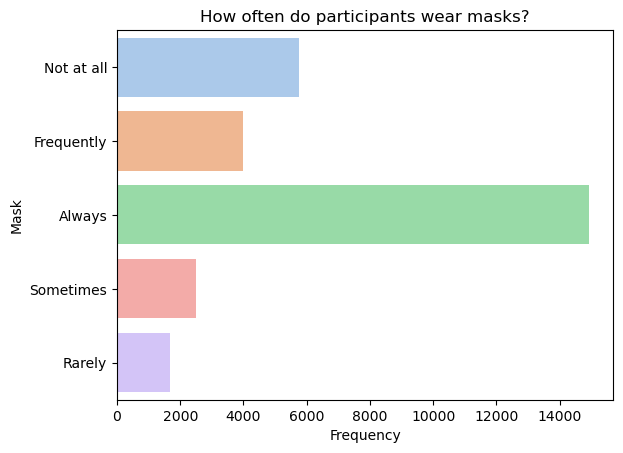

In [10]:
# Plot target
ax = sns.countplot(y = data['Mask'], palette = 'pastel')
ax.set_title('How often do participants wear masks?')
ax.set(xlabel = 'Frequency')

Text(0.5, 1.0, 'Correlation')

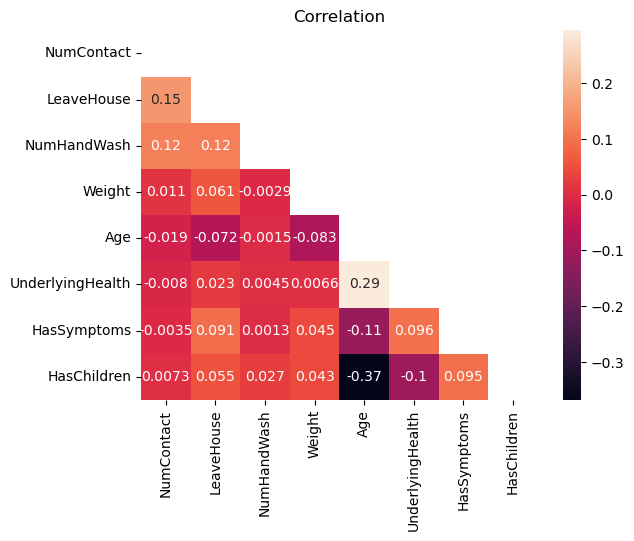

In [11]:
# Correlation
correlation = data.corr(method='pearson')
mask = np.triu(np.ones_like(correlation, dtype=bool))
ax = sns.heatmap(correlation, annot=True, mask = mask)
ax.set_title('Correlation')


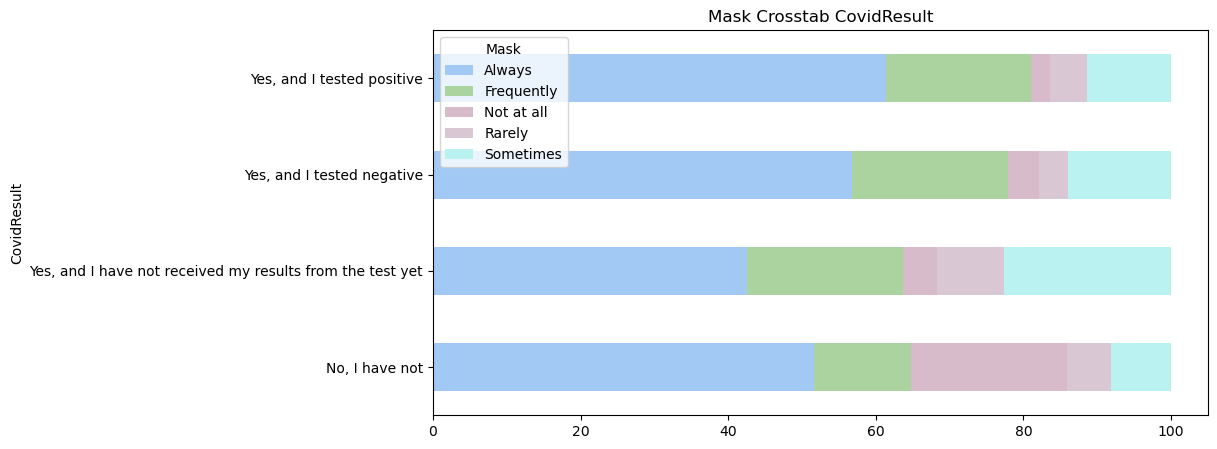

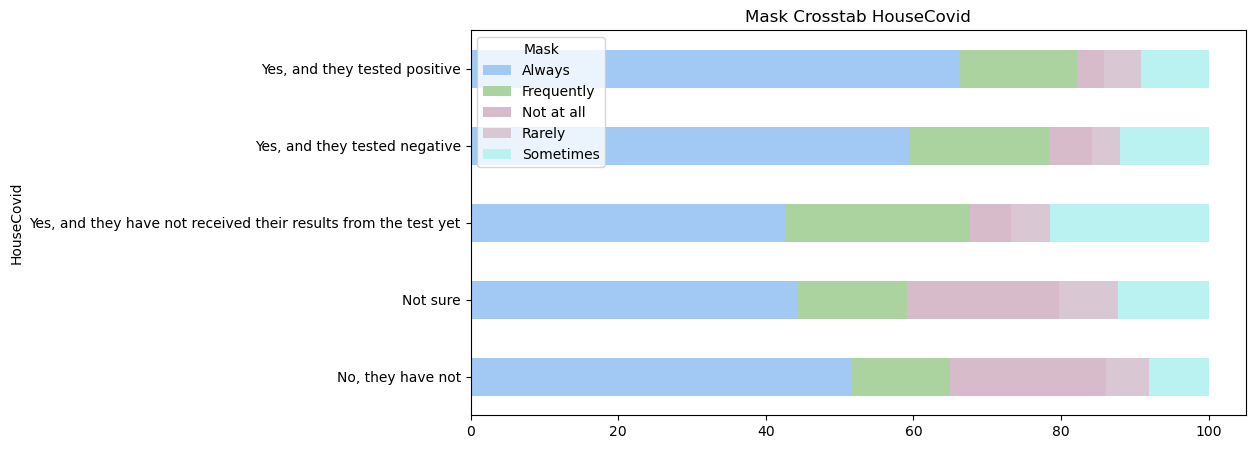

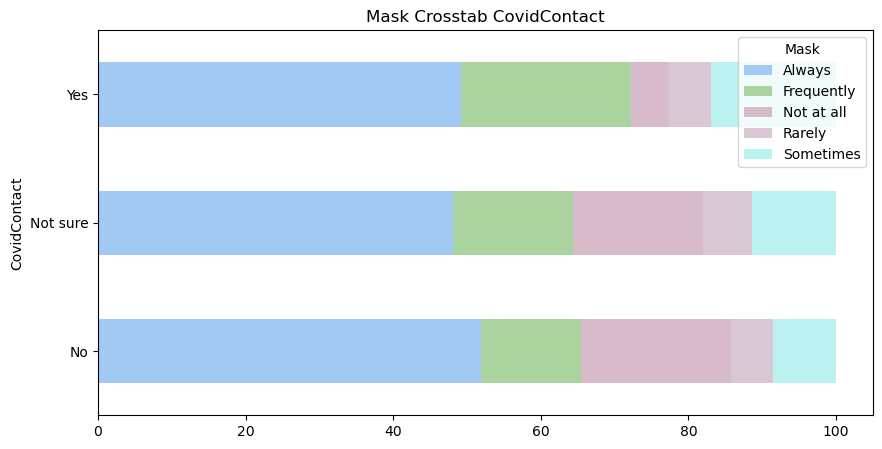

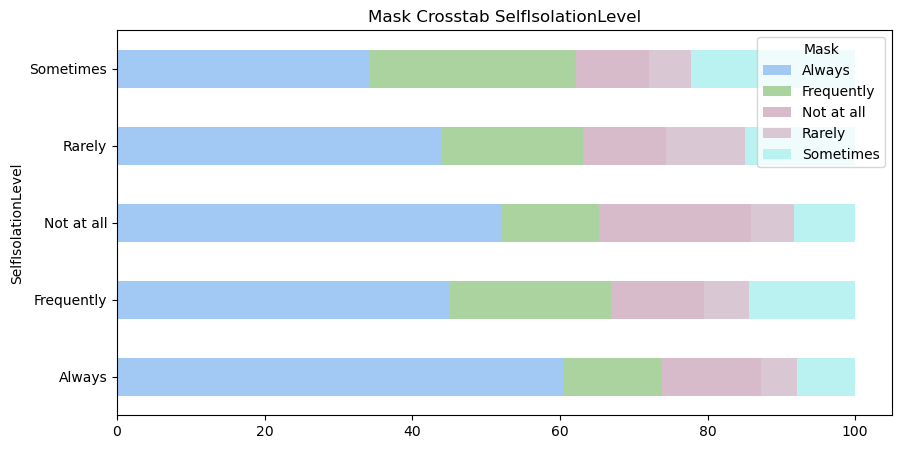

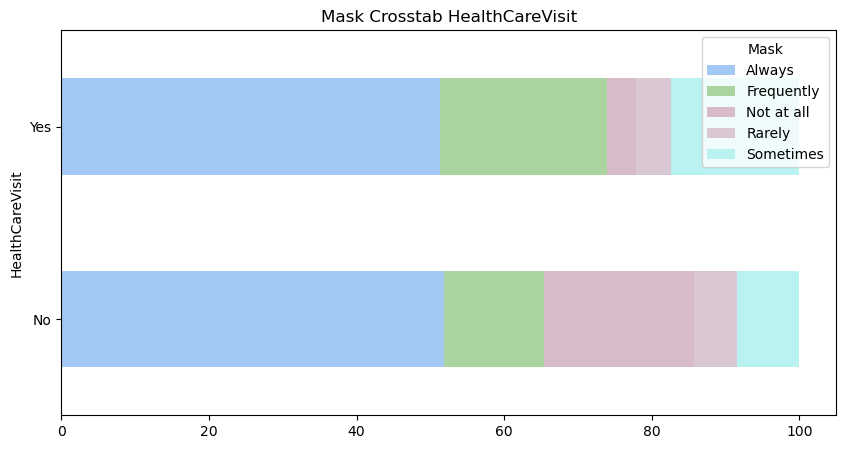

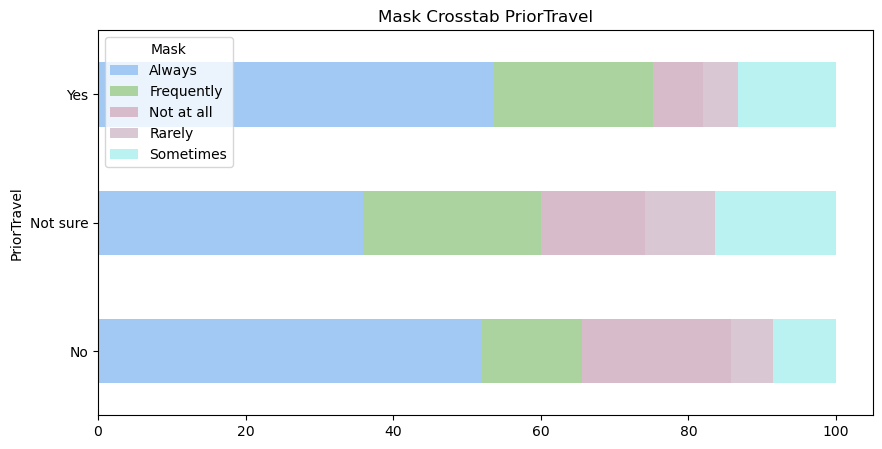

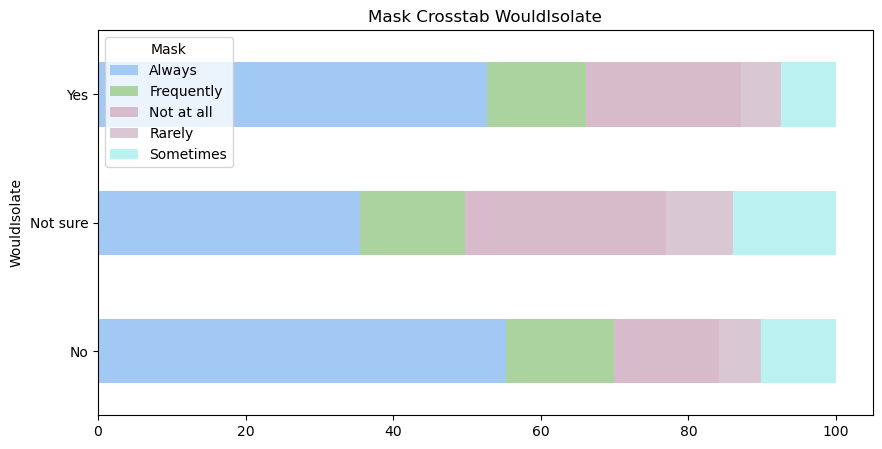

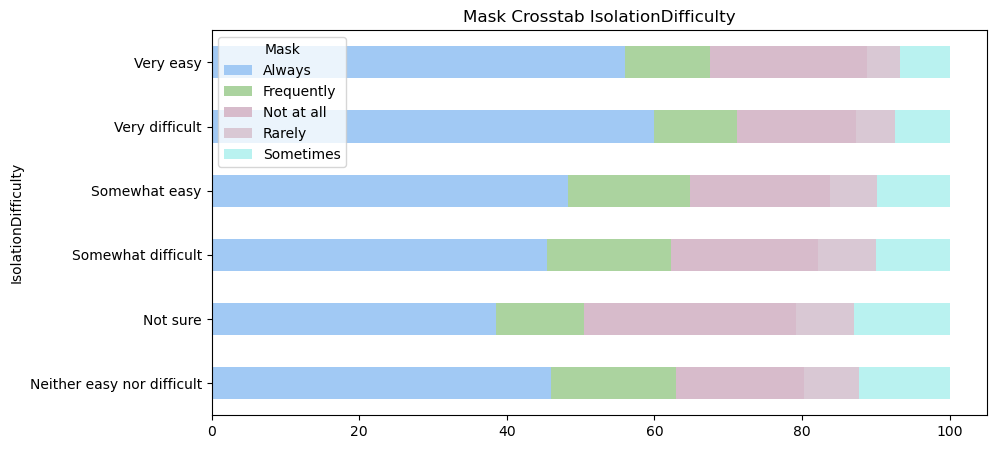

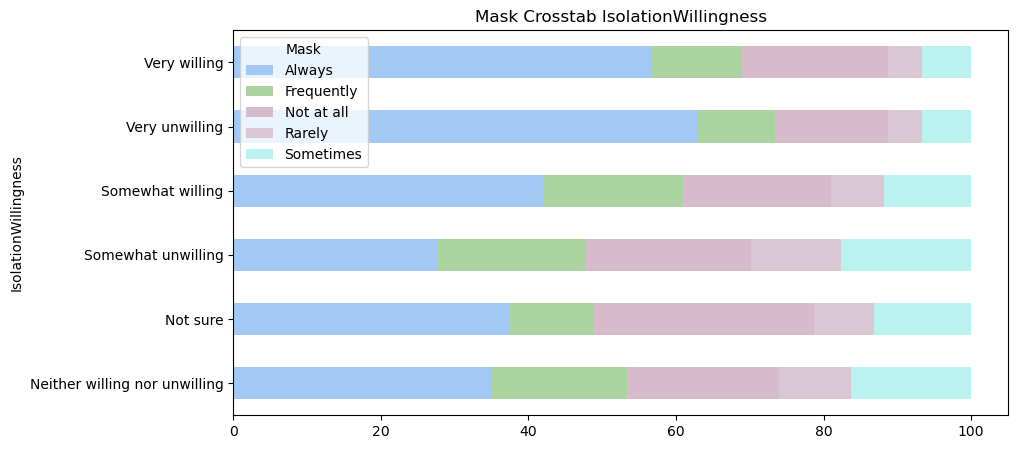

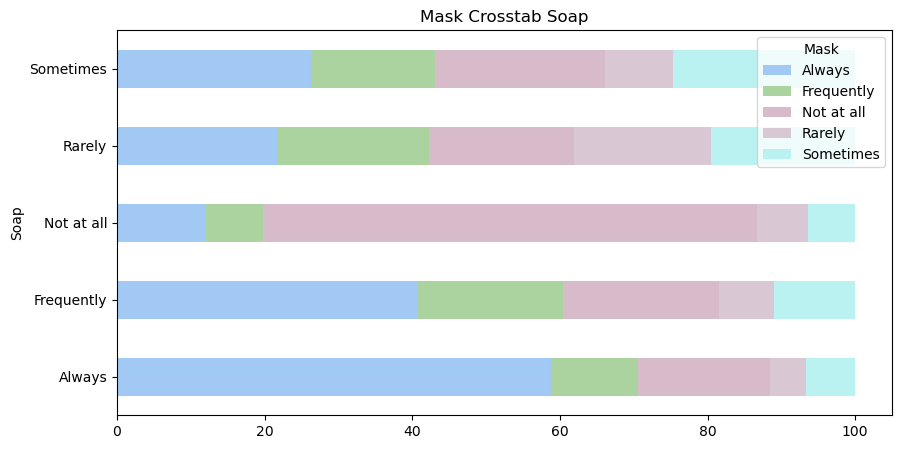

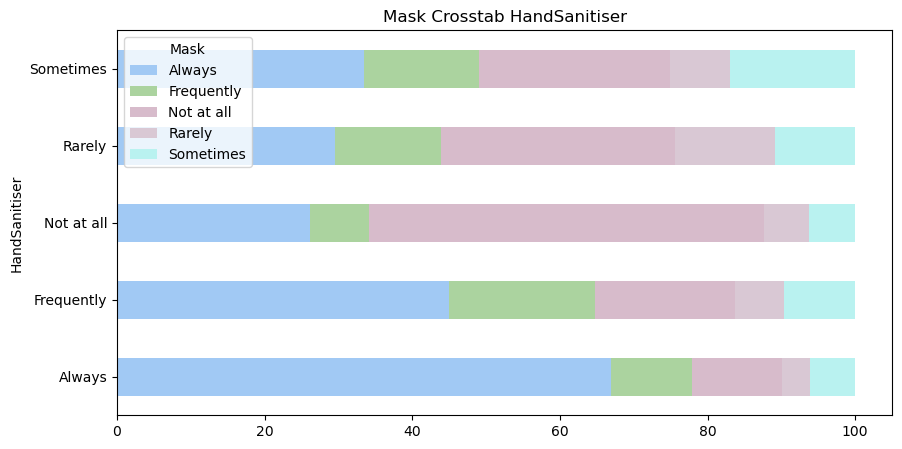

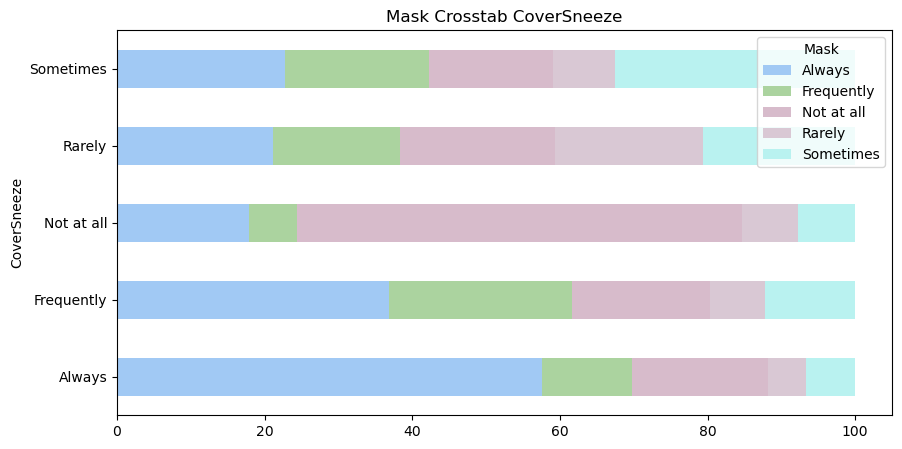

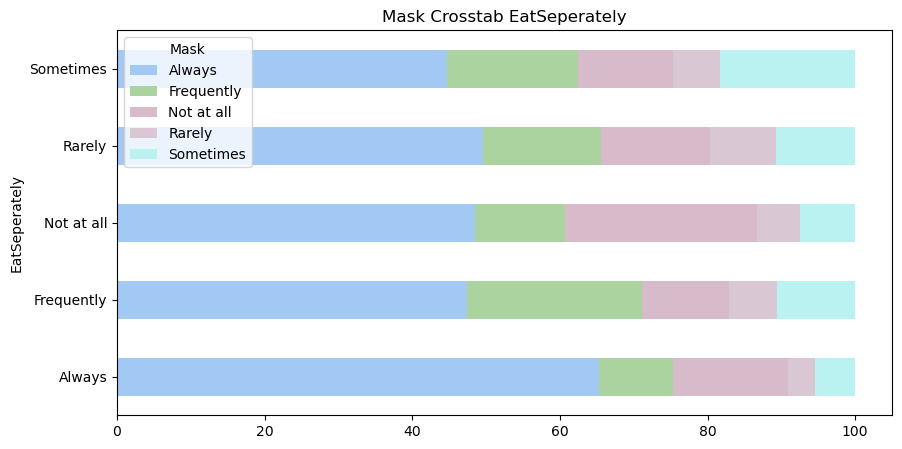

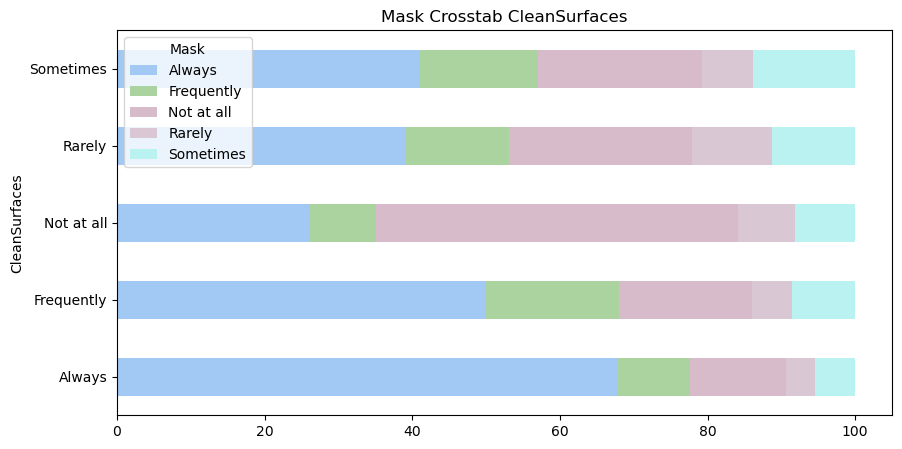

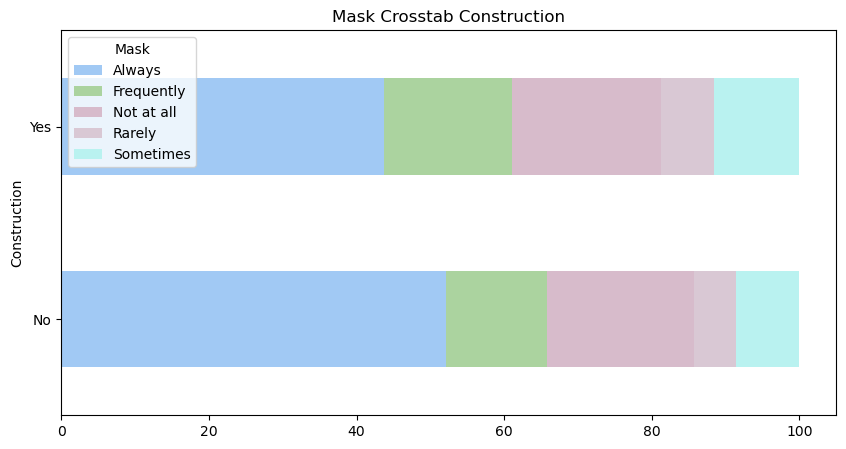

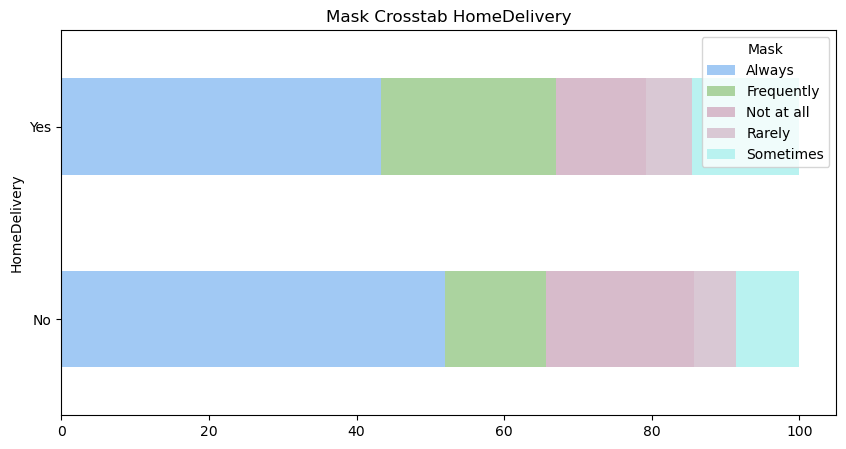

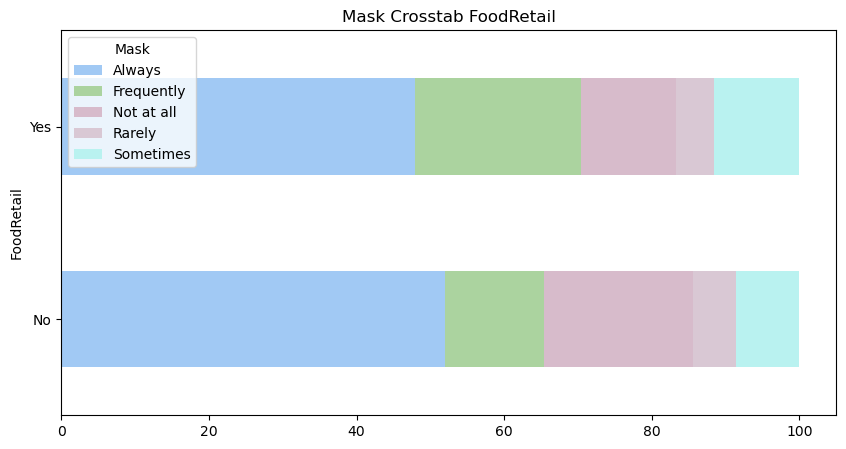

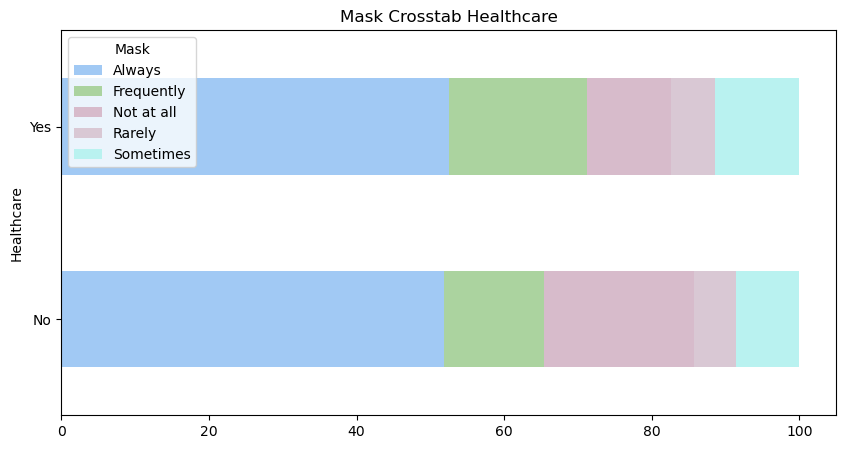

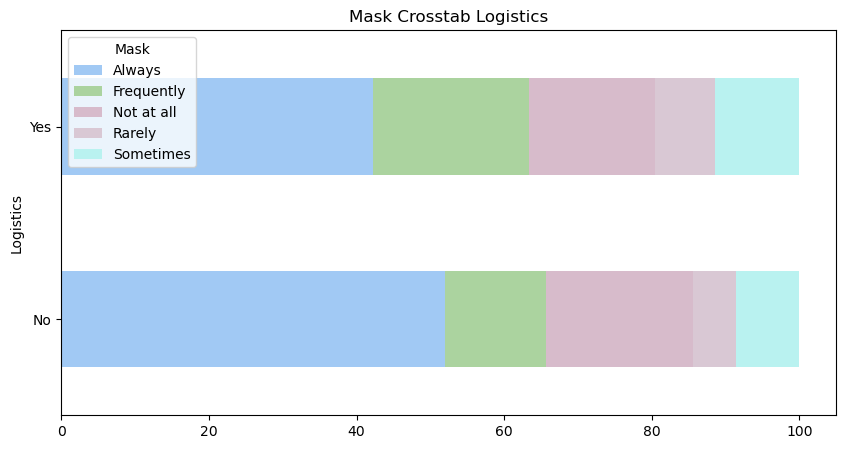

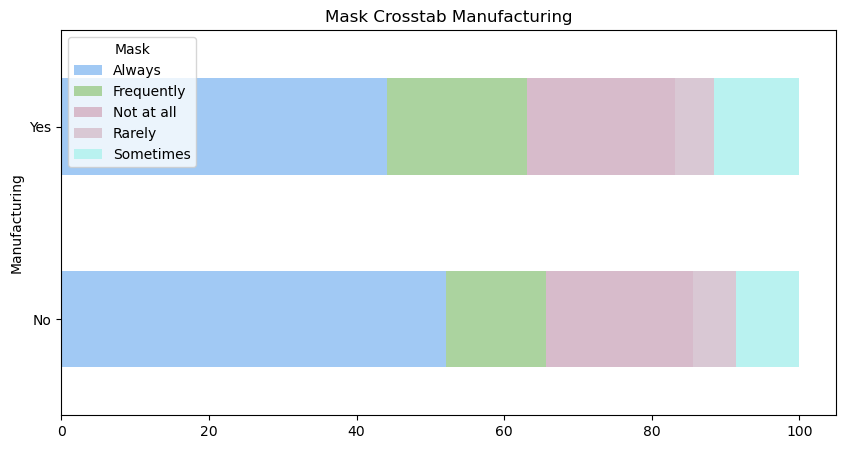

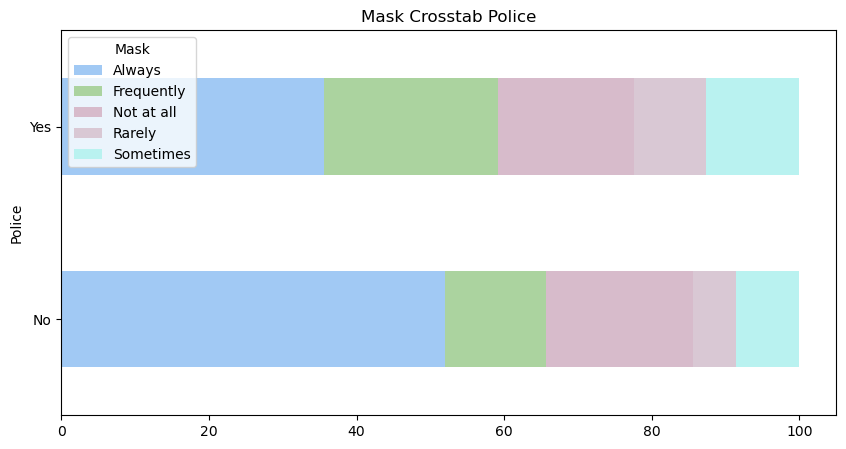

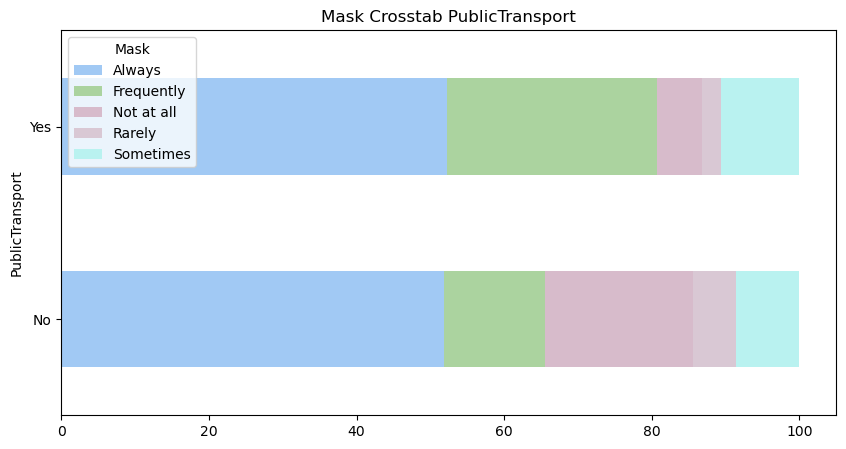

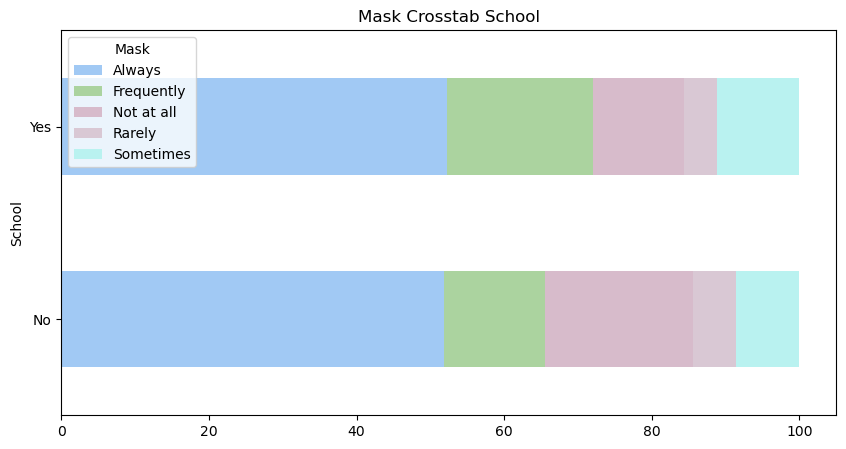

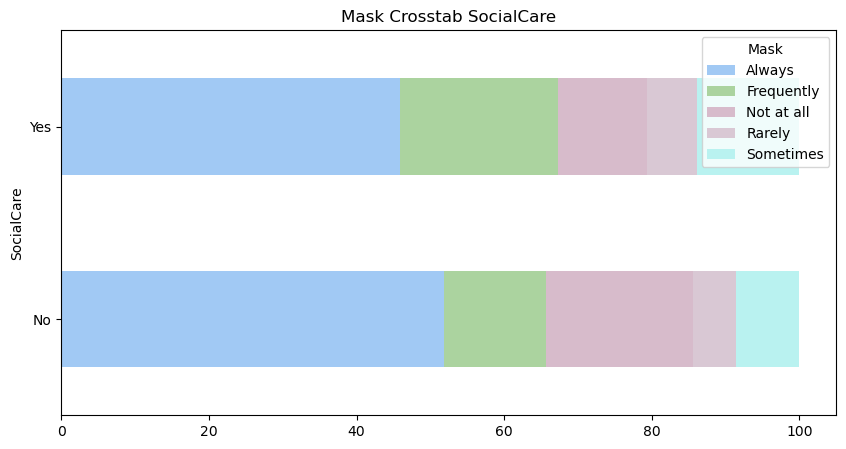

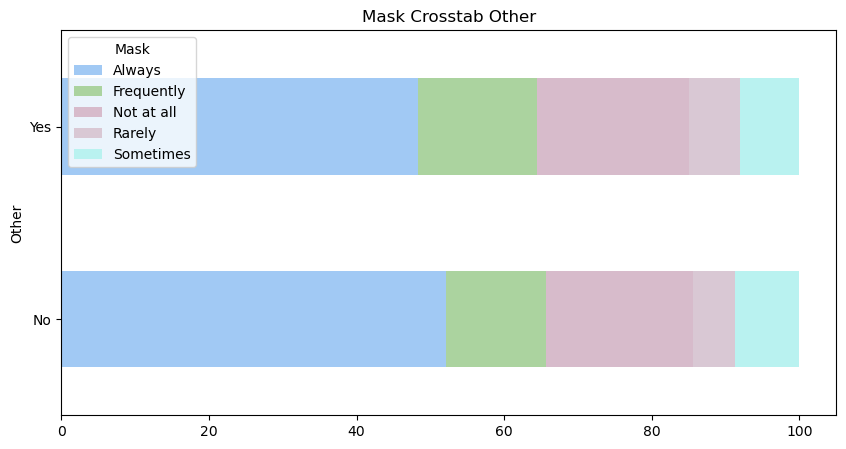

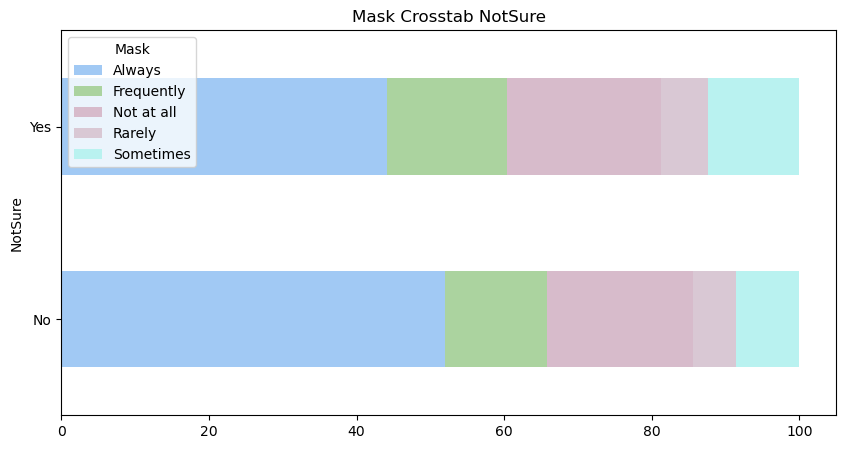

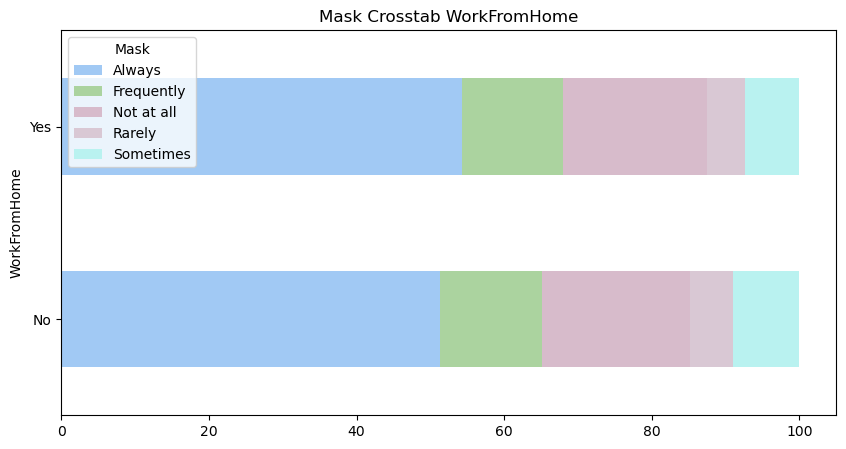

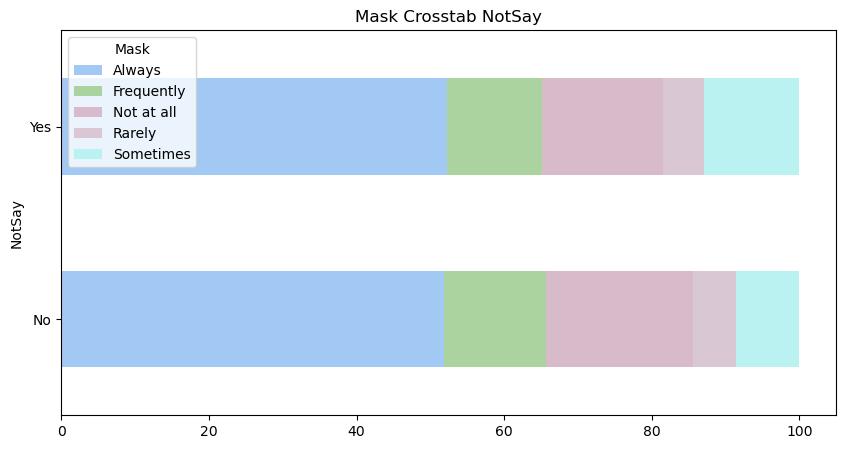

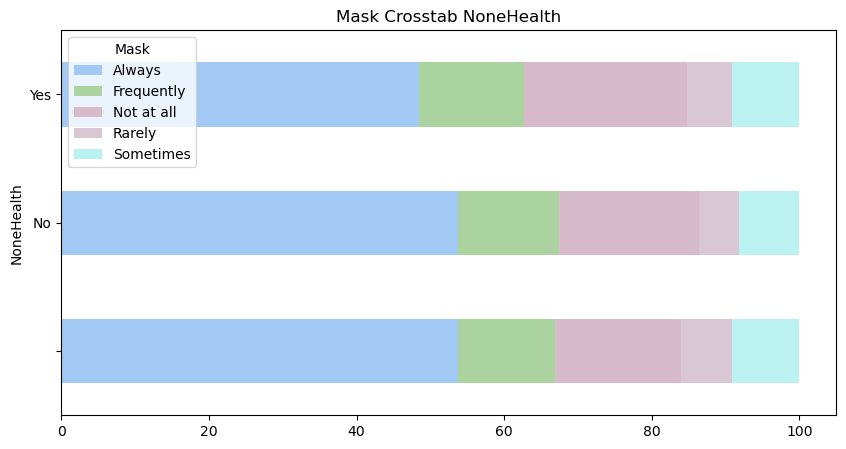

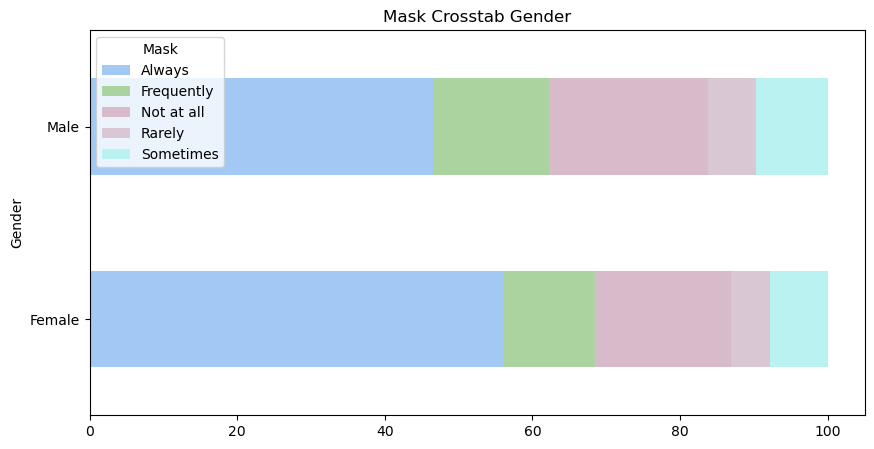

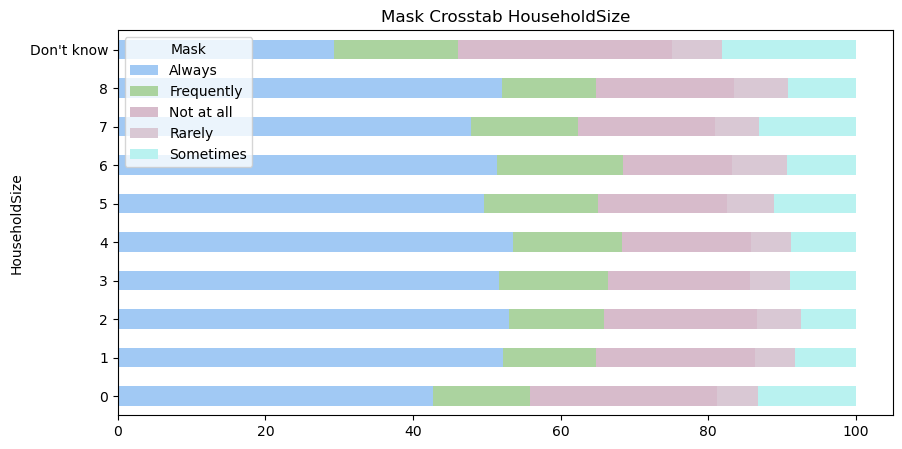

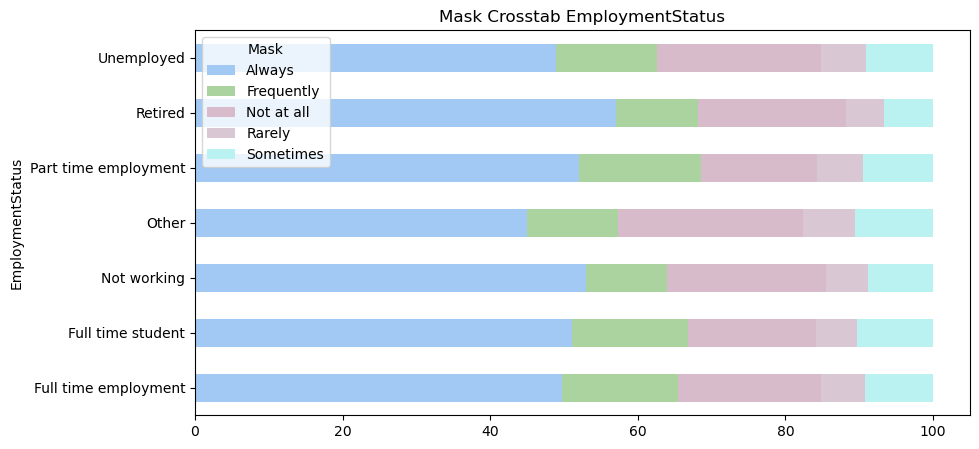

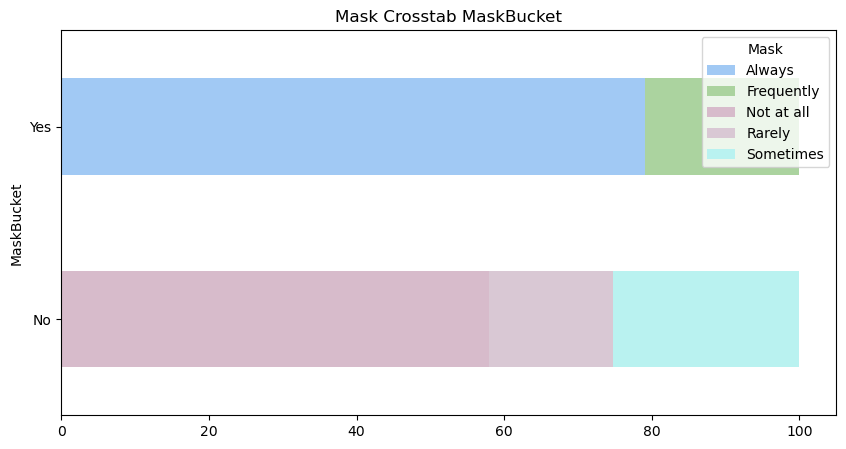

In [12]:
# Crosstab
plt.rcParams.update({'figure.max_open_warning': 0})        
            
for column in data.columns:
    if column != 'Mask' and data[column].dtype == 'object':
        results = pd.crosstab(data['Mask'], data[column])
        results = results.transpose()
        results_normalized = results.div(results.sum(axis = 1), axis = 0) * 100
        
        colours = sns.color_palette('pastel', n_colors=10)
        cmap1 = LinearSegmentedColormap.from_list("my_colormap", colours)
        
        ax = results_normalized.plot(kind = 'barh', stacked = True, figsize = (10,5), colormap = cmap1)
        ax.set_title('Mask Crosstab ' + column)    
       

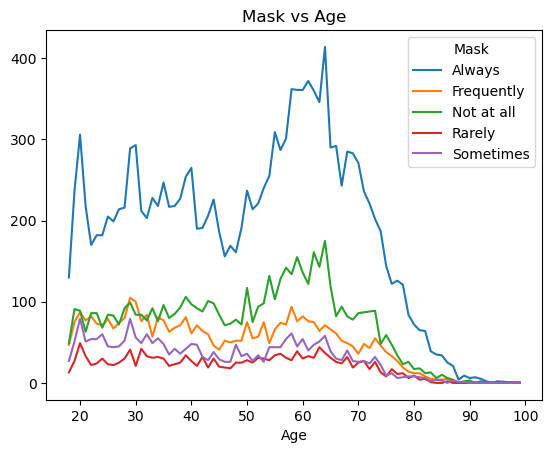

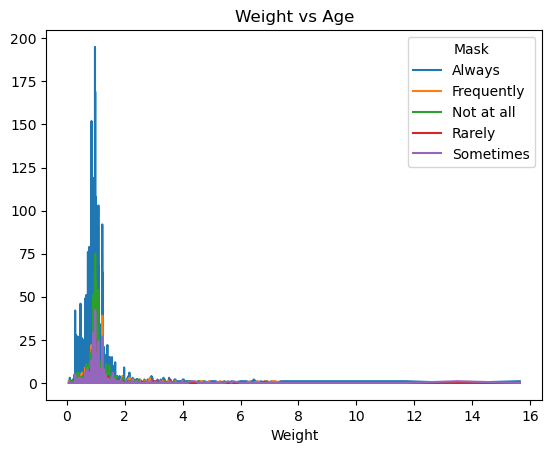

In [13]:
# Check age and weight
crosstab_age = pd.crosstab(data['Age'], data['Mask'])
ax = crosstab_age.plot(kind = 'line', title = 'Mask vs Age')

crosstab_age = pd.crosstab(data['Weight'], data['Mask'])
ax = crosstab_age.plot(kind = 'line', title = 'Weight vs Age')